In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

CBcolors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00',
} 

In [2]:
try: 
    if os.environ["GITHUB_WORKSPACE"] != None:
        root = os.environ["GITHUB_WORKSPACE"]
        inPath = os.path.join(root, "TestComponents", "TestSets", "WS1")
        outPath = os.path.join(root, "TestGraphs", "Outputs")  
        localDayFirst = False
        localDateFormat = '%m/%d/%Y %H:%M:%S'
except: 
    localDayFirst = True
    localDateFormat = '%d/%m/%Y %H:%M:%S %p'
    rootfrags = os.path.abspath('WS1.py').split("\\")
    root = ""
    for d in rootfrags:
        if d == "FieldNBalance":
            break
        else:
            root += d + "\\"
    inPath = os.path.join(root,"FieldNBalance","TestComponents", "TestSets", "WS1")
    outPath = os.path.join(root,"FieldNBalance","TestGraphs", "Outputs")   

In [3]:
Configs = pd.read_pickle(os.path.join(inPath, "FieldConfigs.pkl"))

In [4]:
observedCrop = pd.read_csv(os.path.join(inPath, "CropData.csv"), index_col=0)
observedCrop.sort_index(axis=0,inplace=True)
observedCrop['Date'] = pd.to_datetime(observedCrop['Date'])

In [5]:
observedSoil = pd.read_csv(os.path.join(inPath, "SoilData.csv"),index_col=0)
observedSoil.sort_index(axis=0,inplace=True)
observedSoil['Date'] = pd.to_datetime(observedSoil['Date'])
observedSoil['SoilMineralN'] = observedSoil.loc[:,['SoilN0_15', 'SoilN15_30']].sum(axis=1)

In [6]:
testFiles = []
tests = []
for file in os.listdir(os.path.join(inPath,"Outputs")):
    if file.endswith('.csv'):
        testFiles.append(file)
        tests.append(file.replace(".csv",""))

In [7]:
Alltests =[]
for t in testFiles[:]:  
    testframe = pd.read_csv(os.path.join(inPath, "Outputs", t),index_col=0,dayfirst=localDayFirst,date_format=localDateFormat)  
    Alltests.append(testframe)   

AllData = pd.concat(Alltests,axis=1,keys=tests)
AllData.sort_index(axis=0,inplace=True)
AllData.index = pd.to_datetime(AllData.index)

In [8]:
TestsFrame = pd.DataFrame(index = tests,data=[x.split('_') for x in tests],columns = ['Site','N','Irr','Crop'])

In [9]:
ObsPredIndex = pd.MultiIndex.from_product([tests,AllData.index],names=['Treatment','Date'])
ObsPredCropN = pd.DataFrame(index = ObsPredIndex, columns = ['obs','pred'])
ObsPredCropN.loc[:,'Site'] =  [TestsFrame.loc[x,'Site'] for x in ObsPredCropN.index.get_level_values(0)]
ObsPredCropN.set_index('Site',append=True,inplace=True)
ObsPredCropN = ObsPredCropN.reorder_levels(['Site','Treatment','Date'],axis=0)
ObsPredCropN = ObsPredCropN.sort_index()

In [10]:
ObsCropN = observedCrop.loc[:,['Date','CropN']]
ObsCropN.loc[:,'Date'] = [(ObsCropN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsCropN.index.size)]
ObsCropN.set_index('Date',append=True,inplace=True)
ObsCropN.columns = ['obs']
ObsCropN = ObsCropN.groupby(['Site','Date']).mean()
for t in tests:
    s = TestsFrame.loc[t,'Site']
    obst = TestsFrame.loc[t,'Site']+"_"+TestsFrame.loc[t,'N']+"_"+TestsFrame.loc[t,'Irr']
    obs = ObsCropN.loc[obst,:]
    obs.sort_index(inplace=True)
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
    Pred = AllData.loc[dates,(t,'CropN')]
    pred = Pred.reindex(obs.index.values)
    pred.sort_index(axis=0, inplace=True)
    for d in obs.index.values:
        ObsPredCropN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredCropN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

In [11]:
sites = list(ObsPredCropN.index.get_level_values(0).drop_duplicates())

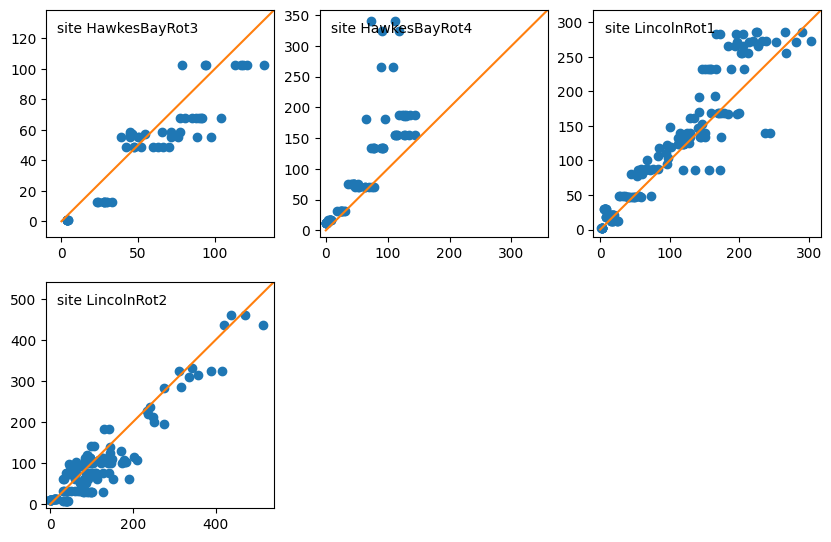

In [12]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in sites:
    Obs = ObsPredCropN.loc[s,'obs']
    Pred = ObsPredCropN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredCropN.loc[s,'obs'].max(),ObsPredCropN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

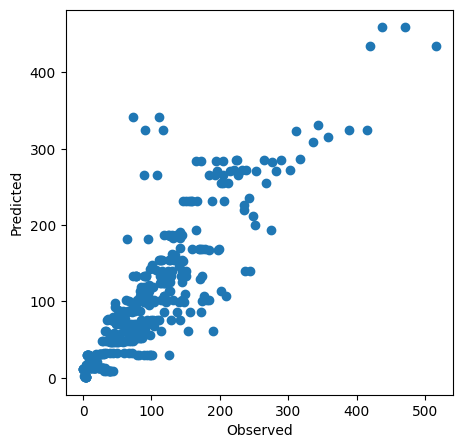

In [13]:
Obs = ObsPredCropN.obs.values
Pred = ObsPredCropN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

In [14]:
ObsSoilN = observedSoil.loc[:,['Date','SoilMineralN']]
ObsSoilN.loc[:,'Date'] = [(ObsSoilN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsSoilN.index.size)]
ObsSoilN.set_index('Date',append=True,inplace=True)
ObsSoilN.columns = ['obs']
ObsSoilN = ObsSoilN.groupby(['Site','Date']).mean()
blankIndex = pd.MultiIndex.from_product([[],[],[]], names = ['site','test','date'])
ObsPredSoilN = pd.DataFrame(index = blankIndex, columns = ['obs','pred'])
for t in tests:
    s = TestsFrame.loc[t,'Site']
    obst = TestsFrame.loc[t,'Site']+"_"+TestsFrame.loc[t,'N']+"_"+TestsFrame.loc[t,'Irr']
    obs = ObsSoilN.loc[obst,:]
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'SoilMineralN')].index
    Pred = AllData.loc[dates,(t,'SoilMineralN')]
    pred = Pred.reindex(obs.index.values)
    for d in obs.index.values:
        ObsPredSoilN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredSoilN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

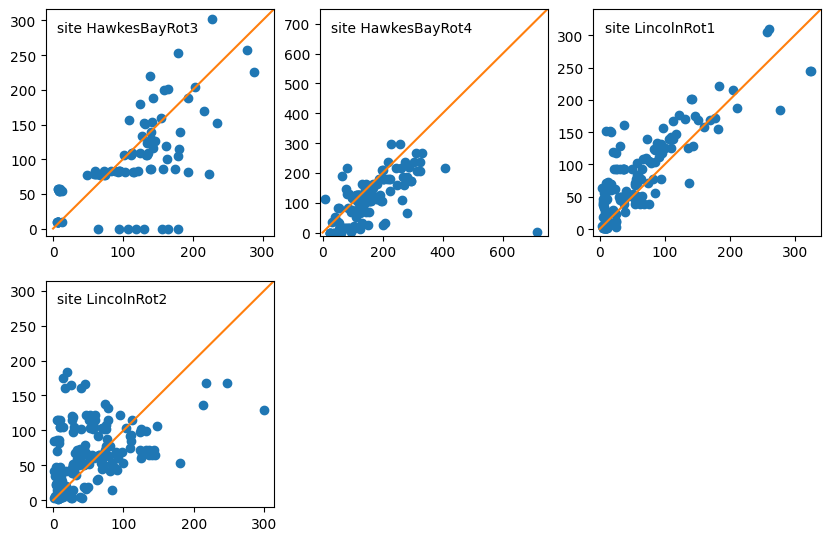

In [15]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in sites:
    Obs = ObsPredSoilN.loc[s,'obs']
    Pred = ObsPredSoilN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredSoilN.loc[s,'obs'].max(),ObsPredSoilN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

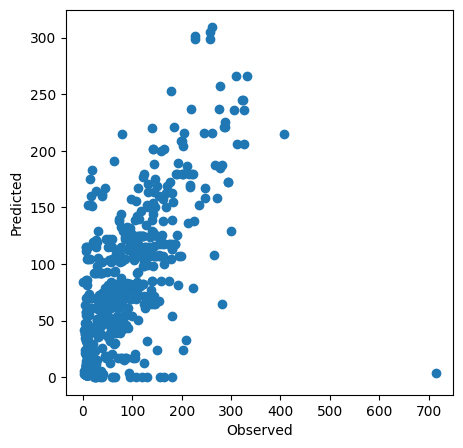

In [16]:
Obs = ObsPredSoilN.obs.values
Pred = ObsPredSoilN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

In [17]:
def setEdgeColor(treat):
    if "_N1_" in treat:
        return CBcolors['red']
    if "_N2_" in treat:
        return CBcolors['orange']
    if "_N3_" in treat:
        return CBcolors['green']
    else:
        return CBcolors['blue']

def setFillColor(treat):
    if "_Irr1_" in treat:
        return 'white'
    else:
        return setEdgeColor(treat)
    
def setLineStyle(treat):
    if "_Irr1_" in treat:
        return '-'
    else:
        return '--'

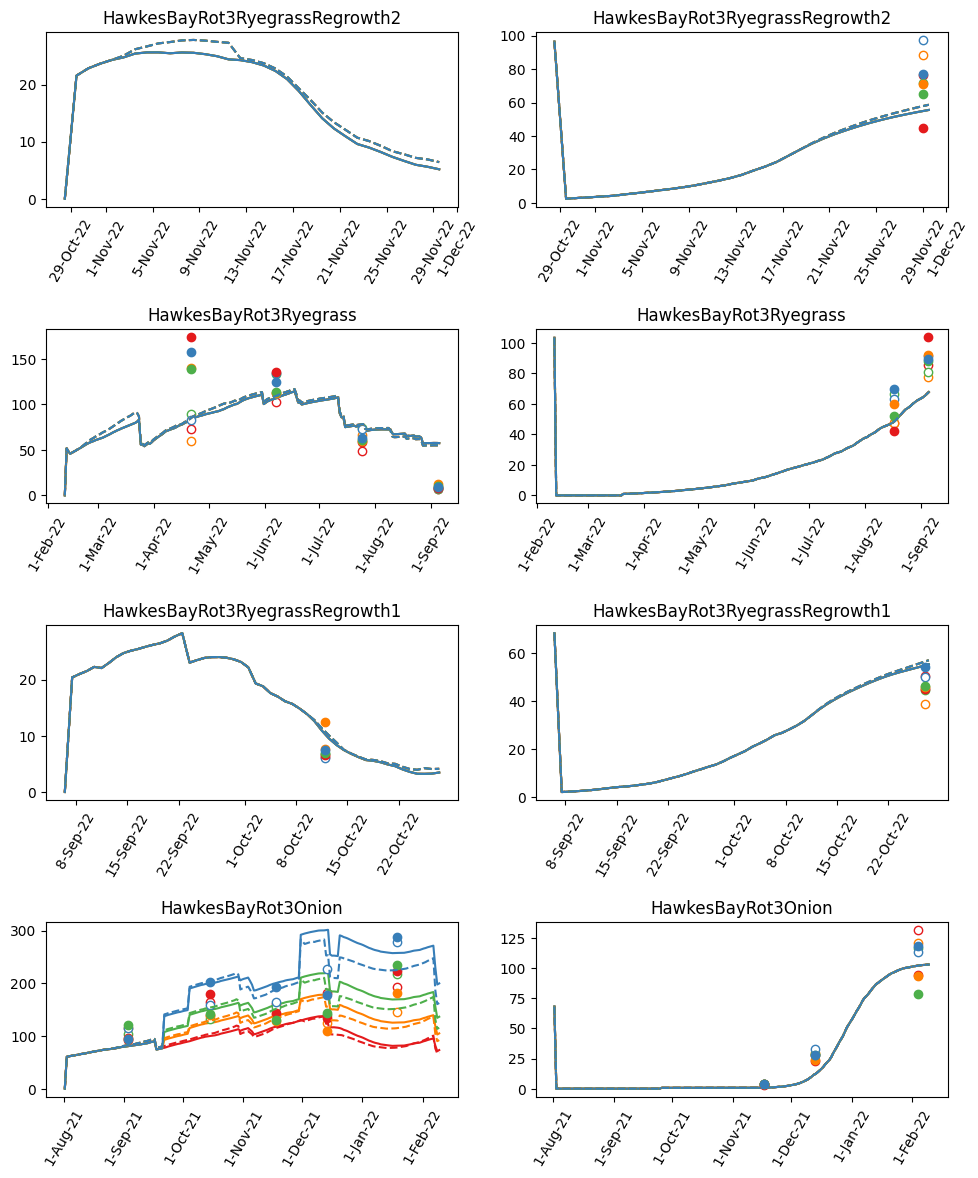

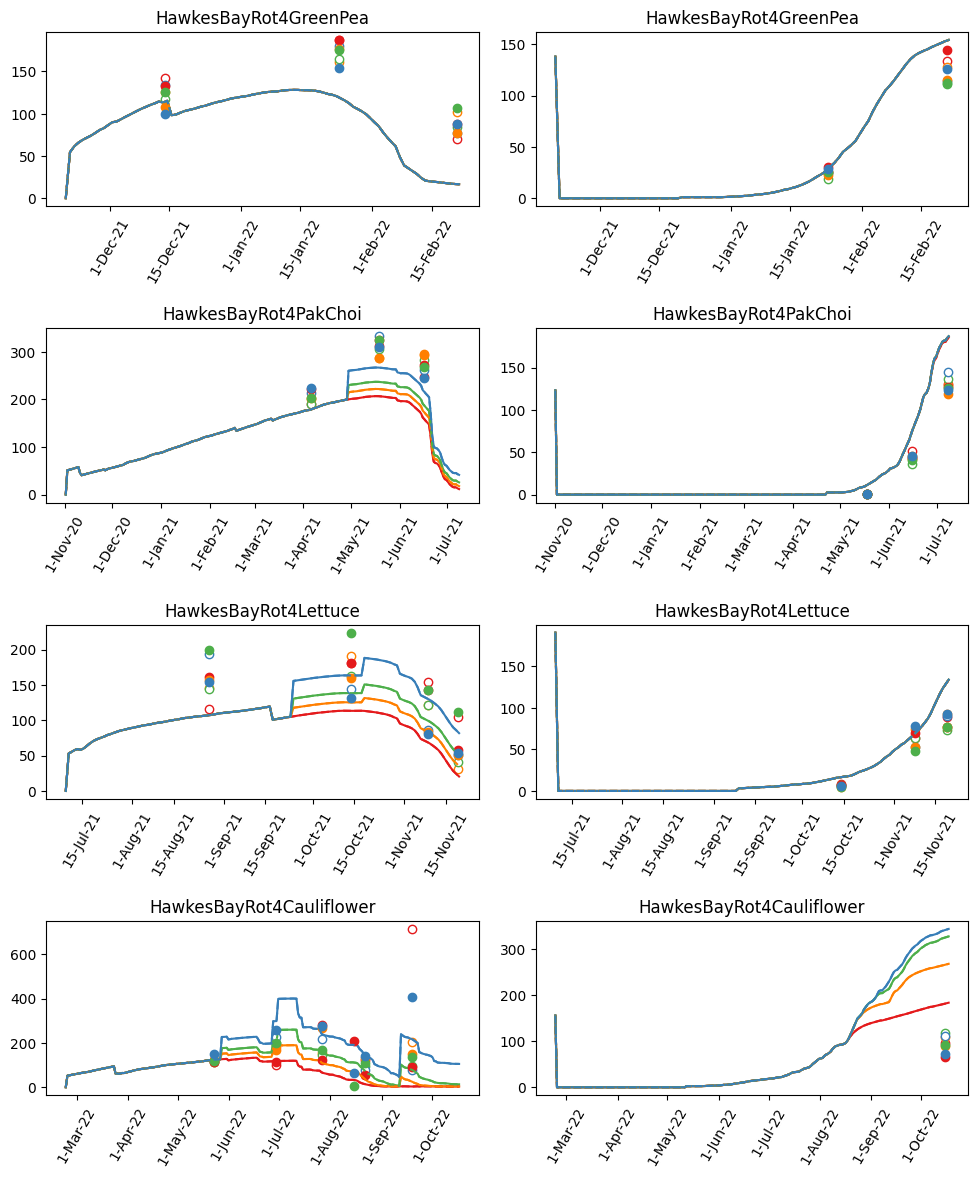

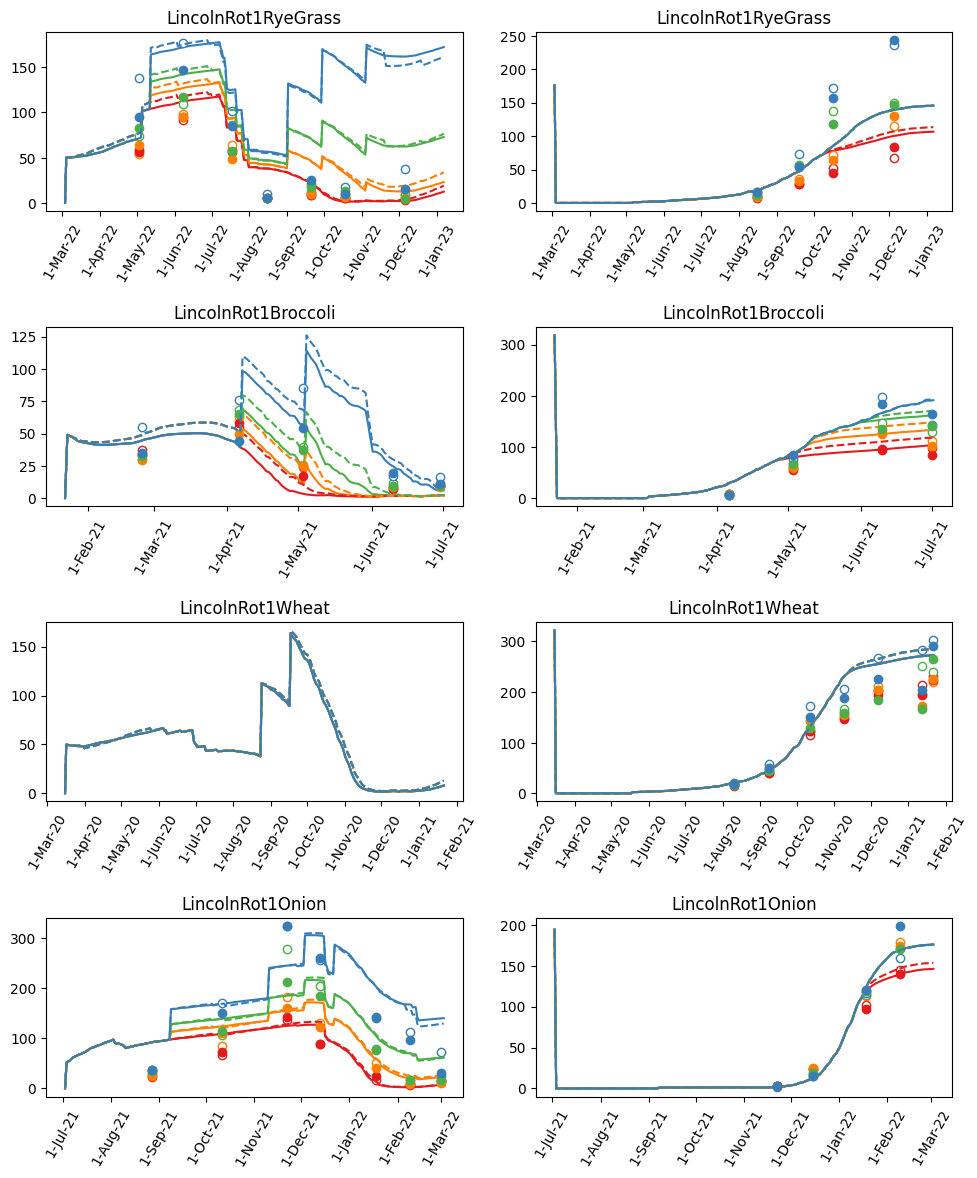

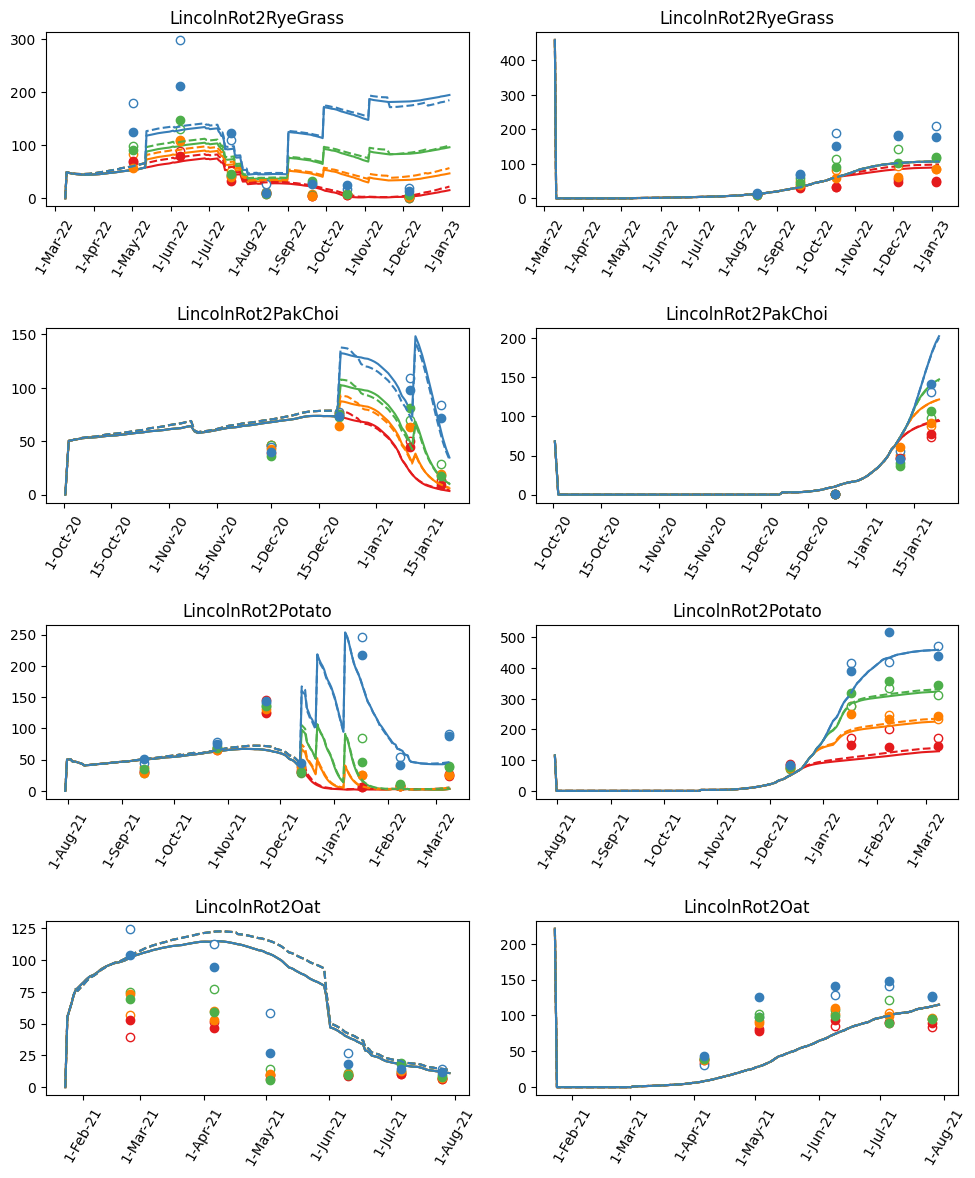

In [18]:
for s in sites:
    Graph = plt.figure(figsize=(10,12))
    testsAtSite = TestsFrame.loc[TestsFrame.Site==s,:].index.values
    cropsAtSite = []
    for t in testsAtSite:
        cropsAtSite.append(t.split("_")[3])
    cropsAtSite = list(set(cropsAtSite))
    pos = 1
    row_num=int(len(testsAtSite)/8)
    for cro in cropsAtSite:
        for v in ['SoilMineralN','CropN']:
            ax = Graph.add_subplot(row_num,2,pos)
            pos+=1
            for i in ['Irr1','Irr2']:
                for n in ['N1','N2','N3','N4']:
                    test = s+"_"+n+"_"+i+"_"+cro
                    mec = setEdgeColor(test)
                    mfc = setFillColor(test)
                    dates = AllData.loc[Configs.loc["PriorHarvestDate",test]:Configs.loc["CurrentHarvestDate",test],(test,v)].index
                    Data = AllData.loc[dates,(test,v)]
                    plt.plot(Data,setLineStyle(test),color=mec,label=i)

                    site = s+"_"+n+"_"+i
                    if v == 'CropN':
                        sData = observedCrop.loc[site,:]
                    if v == 'SoilMineralN':
                        sData = observedSoil.loc[site,:]
                    dFilter = [dates.min() <= sData['Date'].iloc[x] <= dates.max() for x in range(len(sData['Date']))]
                    plt.plot(sData.loc[dFilter,'Date'],sData.loc[dFilter,v],'o',mec=mec,mfc=mfc)
            plt.title(s+cro)
            plt.xticks(rotation=60)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b-%y'))
            #plt.legend()
    Graph.tight_layout(pad=1.5)
    plt.savefig(os.path.join(outPath, "1-WS1_"+s+"TimeCourse.png"))

In [19]:
NbalComponents = ['SoilMineralN', 'UptakeN', 'ResidueN', 'SoilOMN', 'FertiliserN',
       'CropN', 'NDemand','LostN']
accumulate = [False,True,True,True,True,False,False,True]
toAccumulate = dict(zip(NbalComponents,accumulate))

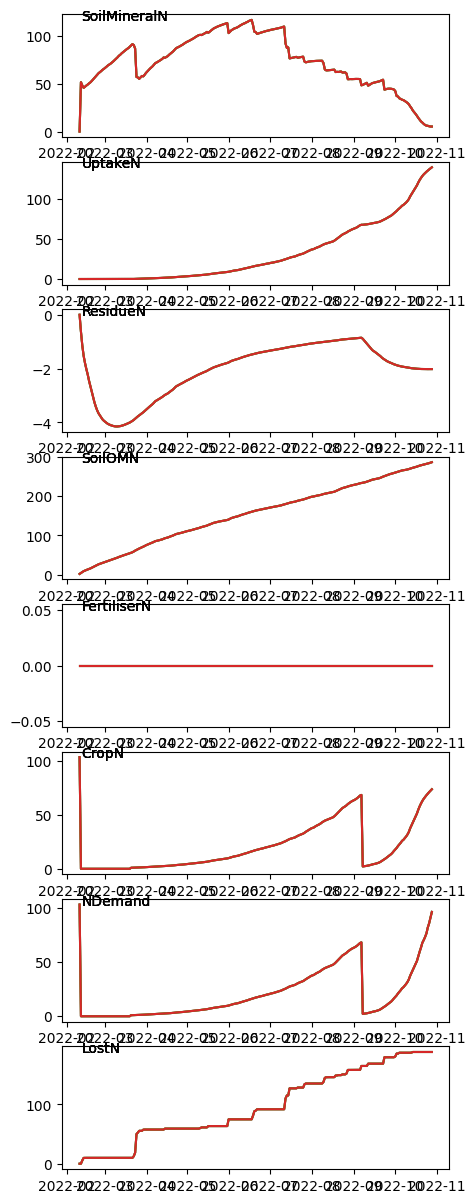

In [20]:
rot = 'HawkesBayRot3_N'
irr = '_Irr2_'
crop = 'Ryegrass'
Graph = plt.figure(figsize=(5,15))
pos = 1
for nbc in NbalComponents:
    ax = Graph.add_subplot(8,1,pos)
    for N in [1,2,3,4]:
        sim = rot+str(N)+irr+crop
        if toAccumulate[nbc] == False:
            CheckData = AllData.loc[:,sim].dropna()
        if toAccumulate[nbc] == True:
            CheckData = AllData.loc[:,sim].dropna().cumsum()
        plt.plot(CheckData.loc[:,nbc],'-')
        plt.text(0.05,0.95,nbc,transform=ax.transAxes)
    pos +=1
# ax = Graph.add_subplot(6,1,2)
# CheckData.UptakeN.cumsum().plot(title='Uptake')
# ax = Graph.add_subplot(6,1,3)
# CheckData.ResidueN.cumsum().plot(title='ResidueN')
# ax = Graph.add_subplot(6,1,4)
# CheckData.LostN.cumsum().plot(title='LostN')
# ax = Graph.add_subplot(6,1,5)
# CheckData.SoilOMN.cumsum().plot(title='SOM')
# ax = Graph.add_subplot(6,1,6)
# CheckData.FertiliserN.cumsum().plot(title='Fert')